# Method 3 - semi-supervised disaggregation, and use partial simulation results as inputs

In [32]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

file_path = r"C:\VITO\MODERATE\synthetic_households_half_simulated.xlsx" # modify to your own directory and file
df = pd.read_excel(file_path) # columns: household_id, floor_area, construction_year, simulated_kWh

In [33]:
# Split the labeled and unlabeled
df_labeled = df[df['simulated_kWh'].notnull()].copy()
df_unlabeled = df[df['simulated_kWh'].isnull()].copy()

In [34]:
# Derived feature
for d in [df_labeled, df_unlabeled]:
    d['age'] = 2025 - d['construction_year']

In [35]:
# Train model on the labeled
X_train = df_labeled[['floor_area', 'age']]
y_train = df_labeled['simulated_kWh']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [36]:
# Predict for unlabeled
X_pred = df_unlabeled[['floor_area', 'age']]
X_pred_scaled = scaler.transform(X_pred)
df_unlabeled['predicted_kWh'] = model.predict(X_pred_scaled)

In [37]:
print (df_labeled)

    household_id  floor_area  construction_year  simulated_kWh  age
0             H1         152               1989    2104.194294   36
1             H2         229               1991    2601.625359   34
2             H3         142               1990    2081.330994   35
3             H4          64               1955    2061.921983   70
4             H5         156               2001    2161.894042   24
..           ...         ...                ...            ...  ...
494         H495         167               1986    2402.388587   39
495         H496          97               1974    1991.743168   51
496         H497         138               1997    2187.516813   28
497         H498         166               2014    2172.491953   11
498         H499         178               2002    2602.620045   23

[499 rows x 5 columns]


In [38]:
print (df_unlabeled)

    household_id  floor_area  construction_year  simulated_kWh  age  \
499         H500          65               2022            NaN    3   
500         H501         238               1964            NaN   61   
501         H502         241               1998            NaN   27   
502         H503         240               2017            NaN    8   
503         H504         118               1961            NaN   64   
..           ...         ...                ...            ...  ...   
995         H996         160               1964            NaN   61   
996         H997         160               1992            NaN   33   
997         H998          83               1997            NaN   28   
998         H999         160               2019            NaN    6   
999        H1000          57               1995            NaN   30   

     predicted_kWh  
499    1731.626189  
500    2527.049016  
501    2516.461044  
502    2406.967507  
503    2022.015956  
..             ...  


In [39]:
# Combine labeled and predicted
df_combined = pd.concat([
    df_labeled[['household_id', 'floor_area', 'construction_year', 'simulated_kWh']].rename(columns={'simulated_kWh': 'predicted_kWh'}),
    df_unlabeled[['household_id', 'floor_area', 'construction_year', 'predicted_kWh']]
])

In [40]:
# Normalize predictions to known total
total_street_kwh = 3000000  # Known total electricity consumption kWh
df_combined['disaggregated_kWh'] = (df_combined['predicted_kWh'] / df_combined['predicted_kWh'].sum()) * total_street_kwh

In [41]:
# Save results to Excel
output_path = r"C:\VITO\MODERATE\semi_supervised_disaggregation.xlsx"
df_combined.to_excel(output_path, index=False)

print("Done! File saved to:", output_path)

Done! File saved to: C:\VITO\MODERATE\semi_supervised_disaggregation.xlsx


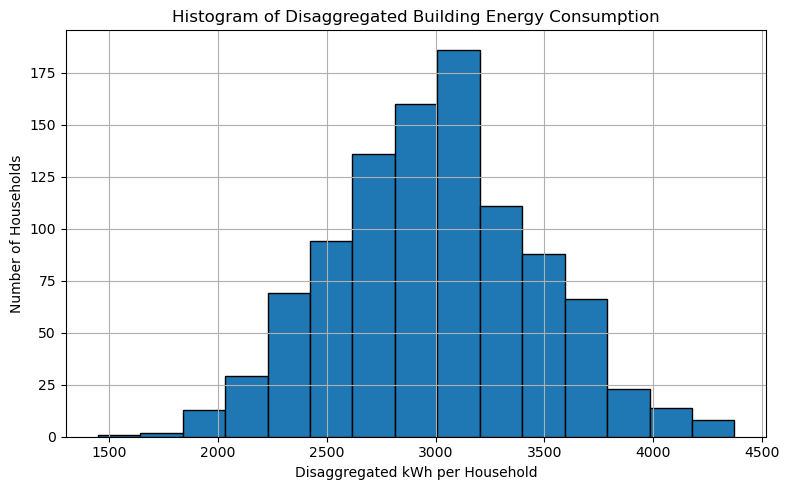

In [42]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_combined['disaggregated_kWh'], bins=15, edgecolor='black')
plt.title('Histogram of Disaggregated Building Energy Consumption')
plt.xlabel('Disaggregated kWh per Household')
plt.ylabel('Number of Households')
plt.grid(True)
plt.tight_layout()
plt.show()

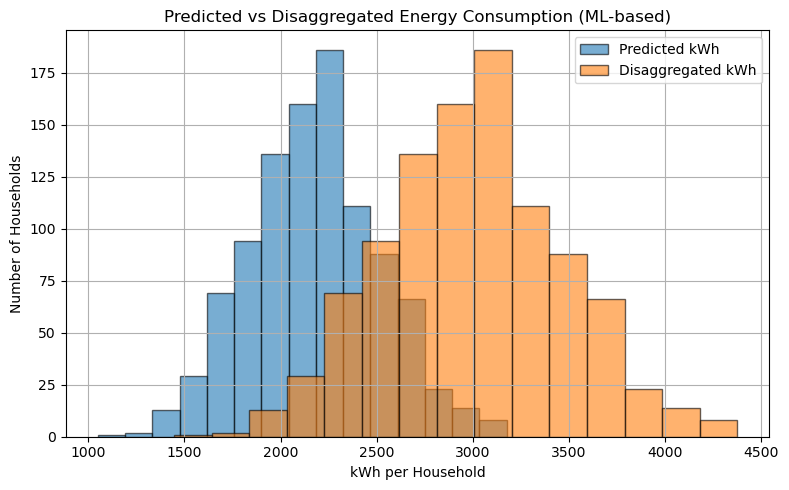

In [46]:
import matplotlib.pyplot as plt

# Plot overlapping histograms
plt.figure(figsize=(8, 5))
plt.hist(df_combined['predicted_kWh'], bins=15, alpha=0.6, label='Predicted kWh', edgecolor='black')
plt.hist(df_combined['disaggregated_kWh'], bins=15, alpha=0.6, label='Disaggregated kWh', edgecolor='black')
plt.title('Predicted vs Disaggregated Energy Consumption (ML-based)')
plt.xlabel('kWh per Household')
plt.ylabel('Number of Households')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()